# Water Resources Assignment

The goal of this assignment is to apply coding strategies to create a model for a multipurpose reservoir while applying several concepts learned in class. The assignment will involve the creatation of a hydrological model of a catchment, tuning the model to fit observed data, modelling 100 years worth of percipitation data from observed data, and modelling a multipurpose dam to analyze flood risk and possible power generation.

Group Members: Ali Waseem, Christina Zarkali, Pia Langhans 

## Part 0: Loading the Data and Installing Libraries

The first step is to load/install the required libraries as well as load the data that was given so that it can be used later on. If the required libraries are not installed in the current environment. Please uncomment the code in the following cell to install them.

In [1]:
# %pip install numpy matplotlib math datetime pandas scipy tqdm 

Below the data provided is loaded and printed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, acos, tan, sin, log, exp, ceil, floor
from datetime import datetime, timedelta
import pandas as pd
from scipy import integrate

#define datapath
data = './project_data/'

P_path = data+'P.txt'
Q_path = data+'Q_obs.txt'
Temp_path=data+'temperature.txt'
kc_path=data+'kc.txt' #Kc... crop coefficient

#load data into python
P = np.loadtxt(P_path, skiprows=1)
Q = np.loadtxt(Q_path, skiprows=1)
temp = np.loadtxt(Temp_path, skiprows=1)
kc = np.loadtxt(kc_path, skiprows=1)

print(P, Q, temp, kc)

[0.0126 0.0236 0.477  ... 0.     0.     0.    ] [ 9.1     9.3353  9.567  ... 31.0894 30.0192 30.0179] [ 3.  2.  5.  7.  9. 14. 18. 17. 15. 10.  6.  4.] [0.2 0.2 0.5 0.7 0.8 1.  1.  1.  0.8 0.6 0.3 0.2]


This notebook was created on Deepnote which has a different screen width default from the regular Jupyter Notebook application. If the plots below are unreadable, the parameters in the next cell can be adjusted to help. After the below cell is changed the cells responsible for plotting will have to be rerun for the effects to be seen.

In [3]:
plt.rcParams['font.size'] = '15'
plt.rcParams['figure.figsize'] = (15,6)

These parameters were inputted into the notebook at this point and then later distributed in relevant sections of the code

In [4]:
#set up parameters
#s_w = 0.25 #wilting point [-]
#s_1 = 0.4 #Soil moisture above which plants transpire at kc*ET0 [-]
#por = 0.3 #Porosity [-], in the slides por = n
#Q_b =7 #Baseflow [m3/s]
#t_sup = 22 #Superficial residence time [h]
#area = 4000 #Area of the basin [km2]
#phi =38 #Latitude of the basin [degrees]

The initial values of `k_sat`, `c`, `t_sub`, and `z` were chosen by taking the mean value of the upper and lower bounds of the possible values for the given variables

In [5]:
#first define K_sat, c, z 
k_sat = 10**(-6) #[m/s]
c = 10 #[-]
t_sub = 200 #mean sub-superficial residence time [h]
z = 1000 #[mm]

## Part 1: The Catchment Model (Hydrological Model/ Model of Drainage Basin)

### 1.1 Making the Model: The Theory

The data provided to the group to begin is 6 years worth of percipitation data that falls within a drainage basin leading to the lake that will eventually hold the multipurpose dam to be modelled. The purpose of the hydrological model is to accurately estimate how much water will enter the lake from the drainage basin and when that water will arrive. As precipitation falls throughout the area of the drainage basin it can follow several different routes that either lead back to the atmosphere or to the lake itself. Each of the possible routes of the water is represented by a mathematical equation that will be used in the model.



#### 1.1.1 Precipitation Falls

When Precipitation falls down and hits the ground there are only two possible places for it to go. Either it can flow along the ground as run off or it can inflitrate the ground and travel through the soil. The equation that will be used for this will be $$R(t) = P(t) - I(t) $$ where $R(t)$ is the run off at a given time step, $P(t)$ is the precipitation at a given time step, and $I(t)$ is the infiltration into the soil at a given time step. Run off and Inflitration are the starting points for the two major path ways that water takes to reach the lake which are above and below ground.



#### 1.1.2 Below Ground

##### 1.1.2.1 Infiltration into the Root Zone


Before run off is able to calculated the infiltration $I(t)$ must be calculated which can be done using the following formula: $$I(t) = min(P(t), K_{sat})$$ Infiltration is equal to the lesser value between the precipitation amount and the saturated hydraulic conductivity which represents the amount of water is able to enter the soil at a given time. What this says is that run off will only occur once $P(t)$ is larger than $K_{sat}\text{. } K_{sat}$ is one of the parameters that can be tweaked in the model to allow it to better fit observed data.

After the water infiltrates the soil it enters the root zone where it can either be absorbed by plants and transpired back into the atmosphere or leach into the soil and become part of the sub-superficial layer. The equation that represents storage of water in the root zone is $$nz\frac{ds}{dt} = I(t) - ET(s,t) - L(s,t)$$ Where $n$ is the porosity of the soil described below, $z$ is the root zone depth, $s$ is the soil moisture described below, $t$ is the time step, $I(t)$ is the infiltration at a given time step, $ET(s, t)$ is the evapotranpiration at a given time step and soil moisture, and $L(t)$ is Leaching at a given time step and soil moisture.

What this means is that water that gets absorbed into the root zone from infiltration can only either stay in the soil increasing the soil moisture, leave the root zone via evapotranspiration, or Leach into the sub-superficial layer. 

$z$ is another parameter that will be adjusted in the model.

##### 1.1.2.2 Evapotransipiration


Evapotransipiration is described by the following equation:
$$ET(s,t)= ET_{0}(t)*K_{c}(t),\ \text{when } s > s_{1}, \text{ when $s>s_{1}$}$$
$$ET(s,t)= \frac{ET_{0}(t)*K_{c}(t)}{s_{1}-s_{w}}*(s-s_{w}), \text{ when  $s<s_{1}$}$$

where $s_{1}$ describes the soil moistre when the "plant" is not water stressed, $s_{w}$ describes the soil moister when the "plant" is beginning to wilt, $ET_{0}(t)$ is the reference crop evapotranspiration calculated using the Thronwaite Method shown below, and $K_{c}(t)$ is the crop coefficient that is representative of the entire catchment.

##### 1.1.2.3 Leaching into the Sub-Superficial Layer

The water in the root zone that does not evapotranspire is also able to leach into the sub-superficial. The equation that represents this is: $$ L(s, t) = K(s) = K_{sat}*s(t)^{c}$$ Where $K(s)$ is the unsaturated hydraulic conductivity and $c$ is an adjustable parameter that effects how much water leaches into the sub-superficial layer at a given $s$. The larger the value of $c$ the more water the soil is able to hold onto and the less leaching occurs.

Once water is leached into the sub-superficial layer the storage of the water in the sub-superfisical layer can be described as: $$\frac{dV_{sub}}{dt} = L(t) - q_{sub}(t)$$ where $V_{sub}$ is the volume of water in the sub-superfisical layer and $q_{sub}$ is the flow of water from the sub-superficial layer into the lake.

##### 1.1.2.4 Flowing Out of the Sub-Superficial Layer

Water leaves the sub-superficial layer according to the following equation: $$q_{sub}(t) = \frac{V_{sub}(t)}{t_{sub}}$$ Where $t_{sub}$ is the sub-superficial residence time. This can be thought of as the average time it takes for a parcel of water in the sub-superficial layer to travel from where it was leached to the lake. $t_{sub}$ is a parameter that can be adjusted in the model to fit observed data.

#### 1.1.3 Above Ground

##### 1.1.3.1 Run Off into the Superficial Layer

Now that the path of the water below ground has been explored and analyzed the next step is to do the same for the path water takes above ground to the lake. The first step is to calculate the run off from the following equation: $$R(t) = P(t) - I(t) $$ The water that runs off above ground enters the superficial layer. The equation that describes the storage of water in the superficial layer is as follows: $$\frac{dV_{sup}}{dt} = R(t) - q_{sup}(t)$$ where $V_{sup}$ is the volue of water in the superficial layer, $q_{sup}$ is the flow of water from the superficial layer into the lake.

##### 1.1.3.2 Flowing Out of the Superficial Layer

Water leaves the superficial layer according to the following equation: $$q_{sup}(t) = \frac{V_{sup}(t)}{t_{sup}}$$ Where $t_{sup}$ is the superficial residence time. This can be thought of as the average time it takes for a parcel of water in the superficial layer to travel from where it started to run off to the lake.

#### 1.1.4 Summation of Flows into the Lake

Now that the path that the water can take into the lake has been described by the equations above it can be summed up at each time step and reported as a total $Q_{out}$. There are two more steps before that summation can occur.

The first step is to multiply $q_{sub}$ and $q_{sup}$ by the total area of the drainage basin to obtain $Q_{sub}$ and $Q_{sup}$. The values of $q_{sub}$ and $q_{sup}$ were caluculated in units of [$m/hour$] and need to be converted to [$m^{3}/hour$] before being added as a discharge.

The second step is to condsider the base flow into the lake from the river before it. The value for $Q_{b}$ is given.

With all of this information the final equation for the catchment model is: $$Q_{out} = Q_{sub} + Q_{sup} + Q_{b}$$

#### 1.1.5 Euler's Explicit Method

In the equations above there are several first order derivate equations that will need to be solved numerically. To do this Euler's Explicit Method will be applied which can be described as the following for a function $V(t)$: 
$$V(t_{0}+\Delta t) \approx V(t_{0})+ \Delta t \frac{dV(t)}{dt}\Big|_{t = t_{0}} $$
Which for water storage equations can be seen as: 
$$V(t_{0}+\Delta t) \approx V(t_{0})+ F(t_{0})_{inflow} - F(t_{0})_{outflow}$$

Using the above method at each timestep the next timestep's volume or soil moisture can be calculated.

#### 1.1.6 Other Equations


These equations help to understand what some of the variables above mean:

__Soil Porosity and Moisture:__

$$V_{total} = V_{solids} + V_{water} + V_{air}$$
$$ n = \frac{V_{air}+V_{water}}{V_{total}}$$
$$s = \frac{V_{water}}{V_{air} +V_{water}}$$

__Thornwaite Method__

$$ET_{o}(m) = 16\frac{N_{m}}{12}\left(\frac{10T_m}{I}\right)^{a}$$
$$ I = \sum \limits_{1}^{12} \left( \frac{T_{m}}{5}\right)^{1.514}$$
$$ a = 6.75*10^{-7}I^{3}-7.71*10^{-5}I^{2} +1.79*10^{-2}I + 0.49$$

Where $N_m$ is the mean daylight hours of month $m$, $T_m$ is the mean temperature of month $m$, $I$ is the heat index, and $a$ is an experimental exponent.

$N_{m}$ is calculated as follows where $N_{d}$ is the mean daylight hours in a day, $\phi$ is the latitude, $D$ is the Julien day, which is the days elapsed from Janurary 1 to the day considered. $N_{m}$ is the mean daylight over all of the $N_{d}$'s in a given month $m$

$$N_{d} = \frac{24\omega_{s}}{\pi}$$
$$\omega_{s} = cos^{-1}(tan(\phi)tan(\delta))$$
$$\delta = 0.409sin(2\pi \frac{D}{365}-1.39)


### 1.2 Making the Model: The Code

With the above understanding it is time to turn the theory into actual code. The way that the code is structured is that the values for $ET_{0}$ and $K_{c}$ will be calculated beforehand and passed into the model. This way when it is time to optimize the model the values of $ET_{0}$ and $K_{c}$ that will not change over each iteration will not need to be recalculated.

Originally the group had thought that the model would have to be able to be run at varying time steps, but then realized that the time step of 1 hour would be fine to use for the whole assignment. Going forward note that the code is only able to be run using a timestep of 1 hour.

`calc_timesteps` is a function that is used to calculate the number of timesteps in a given number of years. The time step required should be inputted in terms of seconds. For instance if the time step required is hours then $dt = 3600s$. 

`ET_pot_n_kc` is a function that returns two matrices that are intended to be the same length as the matrix that will be run in the catchment model. The first matrix contains reference crop evapotranspiration values and the second contains the crop coefficient values.  This was done so that one counter could be used to always access the correct value for each variable. In the future this function could be changed so that it only models one year as the data repeats every year.

`calc_ET` is a function that for a given timestep calculates the amount of evapotranspiration given the soil moisture.

In [6]:
def calc_timesteps(n_years, dt):
    return int(n_years*8760*3600/dt) #returns the number of timesteps

def ET_pot_n_kc(temperature, phi, n_years,kc):
    #first lets just check for some errors
    assert len(kc) ==12,'kc is of the wrong length'

    #Set up some constants and fuctions we will use later
    day_month=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) 
    month_end=np.cumsum(day_month)                     
    month_start=month_end-day_month+1
    get_delta =np.vectorize(lambda x: 0.409*sin(2*pi*x/365-1.39))
    get_omega_s =np.vectorize(lambda x:acos(-tan(phi*pi/180)*tan(x)))
    get_ET_month = np.vectorize(lambda N_m,temp,I,a: 16*N_m/12*((10*temp/I)**a))
 
    #start by getting the mean number of daylight hours per month
    days = np.array(range(1,366,1))
    N_d = np.zeros(365)
    N_d = 24*get_omega_s(get_delta(days))/pi

    #create a matrix in which we can store the average daylight per day for each month
    N_m = np.zeros(12)
    for m in range(12):
        N_m[m] = N_d[month_start[m]-1:month_end[m]].mean()

    #now we are ready to calculate the ETo per month
    I = sum((temperature/5)**1.514) #Heat Index
    a = 6.75e-7*I**3 - 7.71e-5*I**2 + 1.79e-2*I + 0.49 

    ET_monthly = get_ET_month(N_m,temperature,I,a)

    #we are now going to create arrays that will let us match up values one for one with our catchement model
    timesteps = n_years*8760
    ETo_steps = np.zeros(timesteps)
    kc_steps = np.zeros(timesteps)
    
    #set up a time counter
    hour = 0
    hour_year = 8760
    start = datetime(year=2022,month=1,day=1,hour=0,minute=0,second=0) #2022 isn't a leap year
    for step in range(timesteps):
        #this adds the amount of time in the year to the start and then takes the month from the datetime object
        month = (start+timedelta(hours=hour%hour_year)).month #modulo to stay in 2022
        ETo_steps[step] = ET_monthly[month-1]/day_month[month-1]/24/1000 #this takes it from mm/month to m/hour
        #we can also assign the right value of kc
        kc_steps[step] = kc[month-1]
        hour += 1
    
    assert hour/8760 == n_years, f'The loop only ran for {hour/8760} years'
        
    return (ETo_steps,kc_steps) #array with timestep values of ET

#this function will take in integers and return an integer
def calc_ET(s, ET_pot, k_c):
    if s>1 or s<0:
        print(f's is bad, it is {s}')
    #ET_pot should already be in m/h
    s_1 = 0.4 #Soil moisture above which plants transpire at kc*ET0 [-]
    s_w = 0.25 #wilting point [-]
    slope = ET_pot*k_c/(s_1-s_w)
    if s > s_1:
        return ET_pot*k_c
    elif s > s_w:
        return slope*(s-s_w)
    else:
        return 0 #s is below wilting there is no transpiration


The `catchment_model` function below takes in the four adjustable parameters `k_sat`, `c`, `t_sub`, and `z`, precipitation data in [$mm/hour$], the number of years the catchment model should be run for, the combined `ET_pot_kc_list` that is returned from the `ET_pot_n_kc` function, and a boolean that represents whether a mass balance test should be run.

The function returns for each time step the $Q_{out}$ [$m^3/s$], run off [$m/h$], infiltration [$m/h$], soil moisture [$-$], leaching [$m/h$], and actual amount of water evapotranspired [$m^3/h$].

In [7]:
def catchment_model(k_sat, c, t_sub, z, P, n_years, ET_pot_kc_list, test=False):
    #set variables
    area = 4000*1000000 #4000 km^2 to m^2
    t_sup = 22 #Superficial residence time [h]
    k_sat = k_sat*3600 #convert ksat from [m/s] to [m/h]
    z = z/1000 #convert z from [mm] to [m]

    #
    ET_pot,k_c = ET_pot_kc_list    

    #calculate the timesteps
    timesteps = n_years*8760 #This just gives us a value of the total number of time steps

    assert len(ET_pot) == timesteps,'ET_Pot Matrix is the wrong length'
    
    
    P_hourly = P[0:n_years*8760+1]/1000 #convert mm/h to m/h
    assert len(P_hourly) == timesteps,'P is of the wrong length'
    

    #start by making all of the matrices we need
    s = np.zeros(timesteps+1) #set up an array to hold all of the s values
    I = np.zeros(timesteps) #set up an array to hold all of the I values
    ET = np.zeros(timesteps) #set up an array to hold all of the ET values
    L = np.zeros(timesteps) #set up an array to hold all of the L values
    V_sub = np.zeros(timesteps+1) #set up an array to hold all of the V_sub values
    q_sub = np.zeros(timesteps) #set up an array to hold all of the q_sub values
    R = np.zeros(timesteps) #set up an array to hold all of the R values
    V_sup = np.zeros(timesteps+1) #set up an array to hold all of the V_sup values
    q_sup = np.zeros(timesteps) #set up an array to hold all of the q_sup values
    Q_b = np.zeros(timesteps) #set up an array to hold all of the Q_b values
    Q_tot = np.zeros(timesteps) #set up an array to hold all of the Q_tot values
    Q_sup = np.zeros(timesteps) #set up an array to hold all of the Q_sup values
    Q_sub = np.zeros(timesteps) #set up an array to hold all of the Q_sub values

    

    s[0] = 0.5 #This is our inital s value which can be changed if we want
    n = 0.3 #Porosity [-]
    for t in range(timesteps):

        I[t] = min(P_hourly[t], k_sat) # Infiltration [m/hour]

        # Note ET_pot is in m/hour        
        ET[t] = calc_ET(s[t], ET_pot[t], k_c[t]) # Evapotranspiration [m/hour]
        L[t] = (k_sat)* pow(s[t], c) # Leaching [m/hour]

        # Calculate next soil moisture value using euler explicity method
        s[t+1] = s[t]+ (I[t]-ET[t]-L[t])/(n*z) # Soil Moisture [-] (second term is mulitplied by dt = 1[hour])

        # Underground water flow
        q_sub[t] = V_sub[t]/t_sub # q_sub [m/h] (t_sub is in hours)
        # Calculate next volume of sub-terrian water with euler explicit method
        V_sub[t+1] = V_sub[t] + L[t] - q_sub[t] # V_sub [m] (Leaching and q_sub are multiplied by dt = 1[hour])
        

        # Above ground water flow
        R[t] = P_hourly[t] - I[t] # Run off [m/hour]
        q_sup[t] = V_sup[t]/t_sup # q_sup in [m/h] (t_sup is in [hours])
        # Calculate next volume of superficial water with euler explicit method
        V_sup[t+1] = V_sup[t] + R[t] - q_sup[t] # V_sup [m] (Run off and q_sup are multiplied by dt = 1[hour])

    actual_ET = area*ET # actual_ET [m^3/h]
    Q_sub = area*q_sub/3600 # Q_sub [m^3/s]
    Q_sup = area*q_sup/3600 # Q_sup [m^3/s]
    Q_b = np.ones(timesteps)*7 #Baseflow [m^3/s]

    #Sum all of the out flows into the reservoir into the Q_tot array
    Q_tot  = Q_b+Q_sub+Q_sup # Q_tot [m^3/s]
    
    #This is the test code
    if test:
        #first let's do a mass balance
        P_tot = P_hourly.sum()
        R_tot = R.sum()
        L_tot = L.sum()
        ET_tot = ET.sum()
        testMB = P_tot/(R_tot+L_tot+ET_tot+n*z*(s[-1]-s[0]))
        print(f'The mass balance test returns {testMB}')


        #now lets do the flow test
        testQ = (P_tot-ET_tot)/(sum(q_sub+q_sup)+n*z*(s[-1]-s[0])+V_sub[-1]+V_sup[-1])
        print(f'The flow balance test returns {testQ}')

    return Q_tot, R, I, s, L, actual_ET # units [m^3/s], [m/h], [m/h], [-], [m/h], [m^3/h]

### 1.2 Testing the Model

With the model code written it will be tested to ensure that it functions correctly and there isn't any water loss.

In [8]:
#first define K_sat, c, z 
k_sat = 10**(-6) #[m/s]
c = 10 #[-]
t_sub = 100 #mean sub-superficial residence time [h]
z = 1000 #[mm]
phi =38 #Latitude of the basin [degrees]

ET_pot_kc_list = ET_pot_n_kc(temp, phi, 6,kc)
Q_tot, R, I, s, L, ET = catchment_model(k_sat, c, t_sub, z, P, 6, ET_pot_kc_list, test=True)


The mass balance test returns 0.9999999999999996
The flow balance test returns 1.0000000000000087


## Part 2: Finding the Best Fit Parameters of the Catchment Model

### 2.1 Metropolis Algorithm, Simulated Annealing, and Optimization

For the catchment model to properly simulate the drainage basin that the group was provided data for the 4 model parameters (`k_sat`, `c`, `t_sub`, and `z`) need to be adjusted so that they can produce the correct $Q_{out}$ given a particular set of precipitation data. To do this a metropolis algorithm with simulatied annealing will be used to sample the parameter space while using Nash-Sutcliffe Coefficient (NS) as the value to optimize.

#### 2.1.1 Nash-Sutcliffe Coefficient

The Nash-Sutcliffe Coefficent measures the similarlity of two sets of numbers. it ranges from $-\infty \rightarrow 1$ with $1$ representing a perfect match of the two sets. The Nash-Sutcliffe Coefficient for the modelled $Q_{out}$ data can be calculated as follows: 
$$NS=1-\frac{\sum \limits_{t} \bigg( Q_{observed}(t) - Q_{model}(t)\bigg)^{2}}{\sum \limits_{t} \bigg( Q_{observed}(t) - \overline{Q_{observed}(t)}\bigg)^{2}}$$
The optimizer will try to find the set of `k_sat`, `c`, `t_sub`, and `z` that lead to the largest possible NS value meaning that the modelled data is as closely matched to the observed data as possible.

#### 2.1.2 Random Walker

To implement a metropolis algorithm with simulated annealing the group will start with a random walker algorithm that simply randomly samples the parameter space by using random values of `k_sat`, `c`, `t_sub`, and `z`. Each of these random values is obtained by sampling from a truncated normal distribution so that the steps that the random walker takes are usualy not far away from the point that it currently is in, but it still randomly samples the parameter space. The issue with the random walker and optimizing is that to find an optimal point the random walker has to be lucky or randomly sample a large point of the parameter space. There is no way to ensure that the walker will find a local or global minimum.

What this looks like in pseudo code is

- Start at initial position 
- Try new position by drawing new `k_sat`, `c`, `t_sub`, and `z` from truncated normal
- move to new position
- repeat

#### 2.1.3 Greedy Walker

To ensure that the optimizer finds some sort of minimum value it can be changes so that it only moves to a new spot if the new spot has a higher NS value than the inital position. What this means is that each step that the greedy walker takes will lead it to a local minimum. The benefits of a greedy walker is that it is reaches convergence quickly, but it does not sample much of the parameter space. If the parameter space has many local minima the greedy walker can get stuck in a sub-optimal one very quickly, which means that depending on the very first values of `k_sat`, `c`, `t_sub`, and `z` chosen the greedy walker can have a wide range of success in optimzing. The issue here is that the greedy walker samples too little of the parameter space.

What this looks like in pseudo code is

- Try new position by drawing new `k_sat`, `c`, `t_sub`, and `z` from truncated normal
- if new position has higher NS value, move to new spot
- else stay in same spot
- repeat

#### 2.1.4 Metropolis Walker

A metropolis walker is a walker that combines aspects of both the random walker and the greedy walker. The metropolis walker will always move to a new spot if it results in a higher NS value like the greedy walker, but will move to a less optimal spot like the random walker with a certain probability. This means that it doesn't _always_ move to a less optimal, but does sometimes. This allows the metropolis walker to still sample more of the parameter space than the greedy walker, but also allows it to move to more optimized parameter values unlike the random walker. While this optimization algorithm is better than the previous two there is still a small issue. Since there is a static probability that the walker moves to a less optimal spot there is a chance that the walker still does not converge. If a low probabilty to move to a less optimized location is used then very little of the parameter space will be explored because the metropolis walker will act like greedy walker, on the other hand if a high probability to move to a less optimized location is used then there is a chance that the walker never converges. The metropolis walker because of this is not truely fit for optimization as much as it is fit for sampling a parameter space around an optimum. 

What this looks like in pseudo code is:

- Start at initial position 
- Try new position by drawing new `k_sat`, `c`, `t_sub`, and `z` from truncated normal
- if new position has higher NS value move __OR__ `np.random()` < probability,  move to new spot
- else stay in same spot
- repeat

#### 2.1.5 Metropolis Walker with Simulated Annealing

To solve the issue with the metropolis walker not being usable for optimizaiton, the probability of jumping to a less optimal point can be changed through the optimization process where it becomes smaller the longer the optimizer runs. This would mean that at the beginning of the optimization process the parameter space will be sampled more and as the number of iterations increases the probability of moving to a less optimal parameter set decreases meaning that the optimizer will start to converge.  

To achieve this a simulated annealing model can be used where the probability to jump to a less optimal location is modelled by the expression used to model cooling in annealing metals. This formula for this is: $$T_{SA} = exp(-\text{iteration} * \text{cooling rate}) $$ This way as the iteration number increases the "Temperature" or probability for jumping to a less optimial solution decreases exponentially to 0. The cooling rate can be adjusted where a larger cooling rate means that the probability drops quicker with iteration number (faster convergence) and a small cooling rate means that the probability drops slower with iteration number (more feature space sampled).

What this looks like in pseudo code is:

- Start at initial position 
- Try new position by drawing new `k_sat`, `c`, `t_sub`, and `z` from truncated normal
- if new position has higher NS value move __OR__ `np.random()` < $T_{SA}$,  move to new spot
- else stay in same spot
- repeat

### 2.2 Coding the Metropolis Algorithm Optimizer

`get_new_theta` is a function that returns a new value of a parameter by drawing from a truncated normal distribution. 

`T_SA` is a function that gives back the cool rate coefficient at a certain time step.

In [9]:
from scipy.stats import truncnorm

def get_new_theta(current, lower, upper):
    sd = (upper-lower)*0.05
    a = (lower-current)/sd
    b = (upper-current)/sd
    return truncnorm.rvs(a=a, b=b, loc=current, scale=sd)

def T_SA(i,cr):
    return np.exp(-i*cr) #[-]

Below is the implementation and testing of a function that calculates Nash-Sutcliffe coefficient, which will optimized to obtain a model that fits the observed data.

In [10]:
#implement Nash sutcliffe coefficient function
Q_obs = Q
Q_mod = Q_tot
#print(Q_mod)
def NS(Q_obs, Q_mod):
    assert len(Q_obs) == len(Q_mod),'The observed data and modelled data have different lengths'
    return 1- np.sum((Q_obs-Q_mod)**2)/np.sum((Q_obs-Q_obs.mean())**2)
    
print(NS(Q, Q_tot))

0.7462563322234551


Below is the optimizer function that takes in an initial value for each of the parameters in the catchment model, any variables that the catchment model uses to run, the observed Q out (Q_obs) and the cooling rate used for the optimizing. A higher cooling rate means that less of the parameter space will be sampled, but the optimizer will converge faster, while a small cooling rate will sample more of the parameter space, but converge slower.

The return values are stored as a dictionary for ease of use as well as the ability to easily convert the data into a pandas DataFrame for plotting.

In [11]:
from tqdm import tqdm

def optimize(k_sat_1, c_1, t_sub_1, z_1, P, ET_pot_kc_list, Q_obs, cr):
    n_years = int(len(P)/8760)
    
    #I am unsure how changing variables that get passed in goes, so this is to be safe
    k_sat = k_sat_1
    c = c_1
    t_sub = t_sub_1
    z = z_1
    
    #Get our initial point from our inserted values
    Q_mod, _, _, _, _, _ = catchment_model(k_sat, c, t_sub, z, P, n_years, ET_pot_kc_list)
    NS_old = NS(Q_obs,Q_mod)

    #set up what we can return for our graphs
    iter_params=[{
        'k_sat': k_sat,
        'c': c,
        't_sub':t_sub,
        'z':z,
        'T_SA':1,
        'NS':NS_old
    }]

    #set up our while loop variables
    for i in tqdm(range(10000)):
        #take a step
        k_sat_new = get_new_theta(lower=1e-7, upper=1e-5, current=k_sat)
        c_new = get_new_theta(lower=1, upper=20, current=c)
        t_sub_new = get_new_theta(lower=1, upper=400, current=t_sub)
        z_new = get_new_theta(lower=1, upper=2000, current=z)

        #model with the new steps
        Q_mod_new, _, _, _, _, _ = catchment_model(k_sat_new, c_new, t_sub_new, z_new, P, n_years, ET_pot_kc_list)
        NS_new = NS(Q_obs,Q_mod_new)

        if NS_new > NS_old or np.random.uniform() < np.exp((NS_new-NS_old)/T_SA(i,cr)):
            #if the new parameters are better use them to step from next time
            #also move if the next step wasn't too negative
            NS_old = NS_new
            k_sat = k_sat_new
            c = c_new
            t_sub = t_sub_new
            z = z_new

        #add them to the our list of values
        values={
            'k_sat': k_sat_new,
            'c': c_new,
            't_sub':t_sub_new,
            'z':z_new,
            'T_SA':T_SA(i,cr),
            'NS':NS_new
        }

        #append the values to the iter_params list
        iter_params.append(values)

    return {'k_sat':k_sat, 'c':c, 't_sub':t_sub, 'z':z, 'NS':NS_old}, iter_params
        

### 2.2 Run the Optimizer

Starting from the center of the range of possible values for each parameter the optimizer is run and the final values and iterations are returned a dictionary. Those values are then converted into a pandas DataFrame and saved as a csv for future use.

The code has currently been commented out so that the optimizer does not run if the whole notebook is run. If the optimizer is to be run, please uncomment all cells before section __2.3__ For the rest of the code to use the parameters they need to be saved and reloaded.

**NOTE** The optimizer takes approximated 45 mins to run for 10,000 iterations. There is a progress bar that will be displayed when the optimizer is run that can be used to gauge how much time is left until it is finished.

In [12]:
k_sat = 10**(-6) #[m/s]
c = 10 #[-]
t_sub = 200 #mean sub-superficial residence time [h]
z = 1000 #[mm]
phi =38 #Latitude of the basin [degrees]
cr = 1/1200

# Optimizer has been commented out so that we don't accidentally run it again

# ET_pot_kc_list = ET_pot_n_kc(temp, phi, 6,kc)
# final_params, iterations = optimize(k_sat, c, t_sub, z, P, ET_pot_kc_list, Q_obs, cr)

Convert the data into a DataFrame and check the Nash-Sutcliffe coefficient for convergence

In [13]:
# iter_df = pd.DataFrame(iterations)
# plt.plot(iter_df.NS)

Change the value of `itr_num` so that it doesn't overwrite previous data and then save both the iteration values and the best parameters found.

In [14]:
# This has been commented out so we don't overwrite our data
# print(final_params)
# itr_num = 2
# iter_df.to_csv(f'./project_data/group_S_iterations_{itr_num}.csv')
# pd.DataFrame([final_params]).to_csv(f'./project_data/group_S_final_params_{itr_num}.csv')

### 2.3 Check and Plot Optimizer Data (Deliverables 1, 2, 3, and 4)

Now that we have our parameter values that we will use going forward, let's test them out with the catchment model and make sure no errors are returned.

In [15]:
#Load the previous data (change the itr_num to match whichever one you wish to use)

best_params = pd.read_csv('./project_data/group_S_final_params_1.csv')
all_iterations = pd.read_csv('./project_data/group_S_iterations_1.csv')

#first define K_sat, c, z 
# k_sat = 9.58e-7 # [m/s]
# c = 7.27 # [-]
# t_sub = 68.38 # mean sub-superficial residence time [h]
# z = 549.53 # [mm]
# phi =38 # Latitude of the basin [degrees]

k_sat = best_params['k_sat'].loc[0] # [m/s]
c = best_params['c'].loc[0] # [-]
z = best_params['z'].loc[0] # mean sub-superficial residence time [h]
t_sub = best_params['t_sub'].loc[0] # [mm]

ET_pot_kc_list = ET_pot_n_kc(temp, phi, 6,kc)
Q_tot, R, I, s, L, ET = catchment_model(k_sat, c, t_sub, z, P, 6, ET_pot_kc_list, test=True)

NS(Q, Q_tot)

The mass balance test returns 0.9999999999999998
The flow balance test returns 1.0000000000000002


0.8773833106661085

__Deliverable 1:__ Report the best fit parameters for the hydrological model.

In [16]:
display(best_params)

,Unnamed: 0,k_sat,c,t_sub,z,NS
0,0,9.580109e-07,7.274281,68.38554,549.534791,0.877383


In [17]:
print(f'The following are the best parameters found by the model:')
print(f'k_sat was found to be {str(best_params.k_sat.values[0])[:4]}{str(best_params.k_sat.values[0])[-4:]} [m/s]')
print(f'c was found to be {str(best_params.c.values[0])[:4]} [-]')
print(f't_sub was found to be {str(best_params.t_sub.values[0])[:5]} [hours]')
print(f'z was found to be {str(best_params.z.values[0])[:6]} [mm]')



The following are the best parameters found by the model:
k_sat was found to be 9.58e-07 [m/s]
c was found to be 7.27 [-]
t_sub was found to be 68.38 [hours]
z was found to be 549.53 [mm]


__Deliverable 2:__ Plot the time series (6-year-long) of precipitation in [mm/h], run off in [mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in [mm/h] for the calibrated hydrological model forced by the given precipitation).

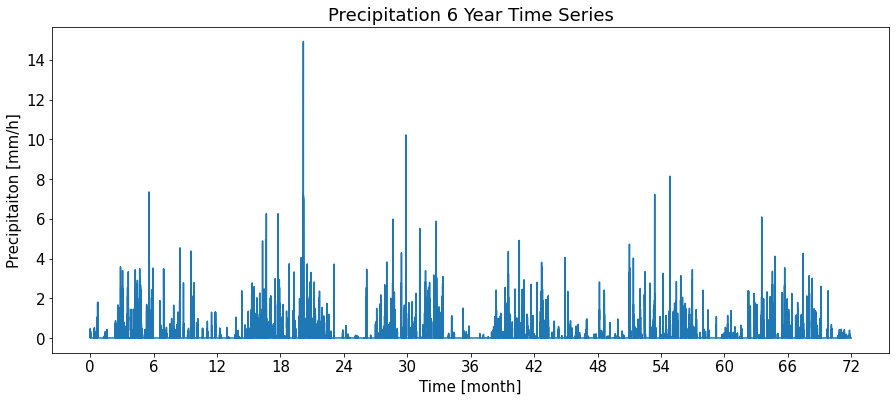

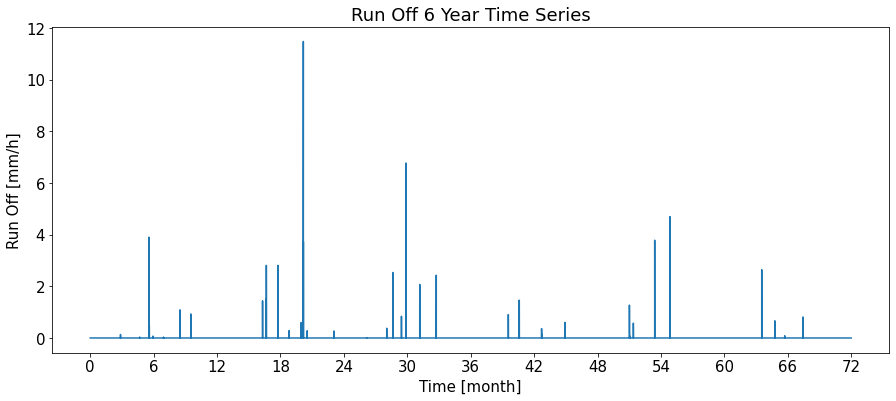

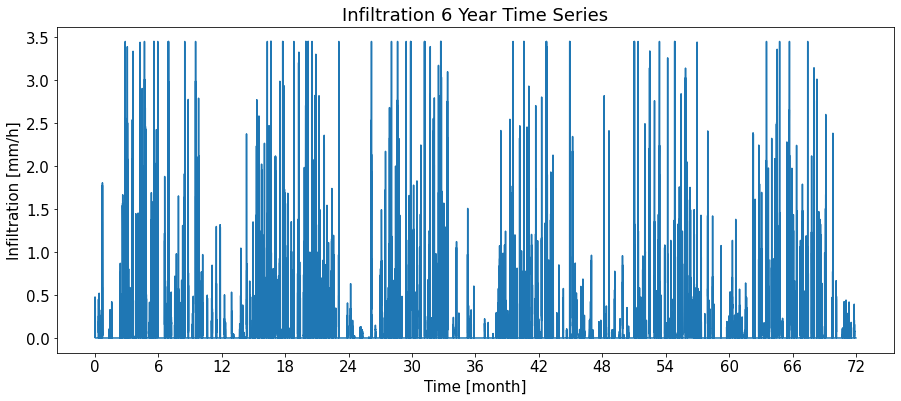

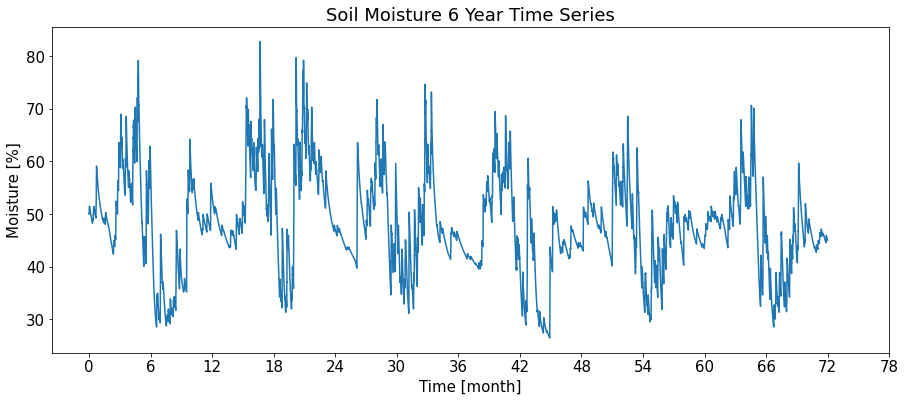

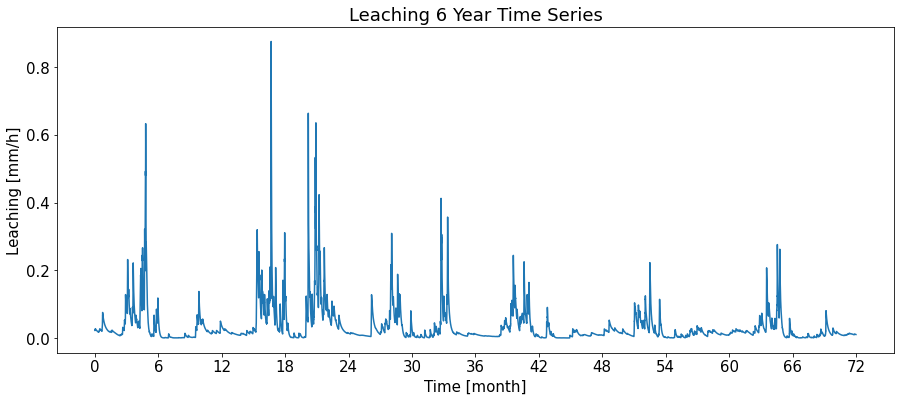

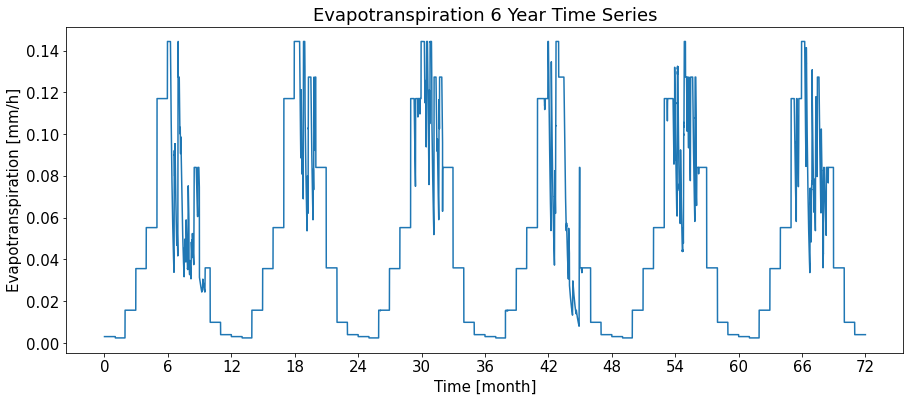

In [18]:
#First convert data from m/h to mm/h as needed. Note that ET was in m^3/h so it needs to be divided by area
P_mm, R_mm, I_mm, L_mm, ET_mm, s_perc = P, R*1000, I*1000, L*1000, ET*1000/(4000*1000000), s*100 

#Gather data into lists so that it can be plotted in a for loop
info = [P_mm, R_mm, I_mm, s_perc , L_mm, ET_mm ]
titles = ['Precipitation', 'Run Off', 'Infiltration', 'Soil Moisture', 'Leaching', 'Evapotranspiration']
y_axes = ['Precipitaiton [mm/h]', 'Run Off [mm/h]', 'Infiltration [mm/h]', 'Moisture [%]', 'Leaching [mm/h]', 'Evapotranspiration [mm/h]']

#create a vectorized function to edit labels
def round_label(x):
    return round(x)
rounder = np.vectorize(round_label)

#run for loop and plot all figures
for var, title, ylab in zip(info, titles, y_axes):
    plt.figure()
    plt.plot(var)
    plt.title(f'{title} 6 Year Time Series')
    plt.ylabel(ylab)
    plt.xlabel('Time [month]')
    #plt.xticks(ticks=[0,8760,17520,26280,35040, 43800], labels=[1,2,3,4,5,6]) # Uncomment if plots are to be in years
    plt.xticks(ticks=np.arange(0,len(var)+8760/2,8760/2), labels= rounder(np.arange(0,len(var)/8760*12 +6, 6)))

__Deliverable 3:__ Plot the time series of observed discharge and of the discharge as simulated by the hydrological model with the best fit parameters.

Text(0, 0.5, 'Discharge [$m^3$/s]')

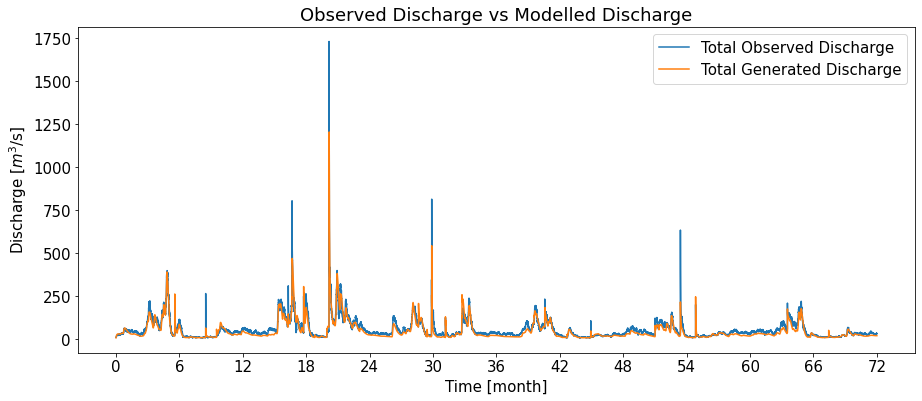

In [19]:
#time series for both observed and generated discharge (m3/s) for 6 years
plt.figure()
plt.plot(Q, label='Total Observed Discharge')
plt.plot(Q_tot, label='Total Generated Discharge')
plt.legend()
plt.title('Observed Discharge vs Modelled Discharge')
plt.xlabel('Time [month]')
plt.xticks(ticks=np.arange(0,len(Q)+8760/2,8760/2), labels= rounder(np.arange(0,len(Q)/8760*12 +6, 6)))
plt.ylabel('Discharge [$m^3$/s]')

__Deliverable 4:__ Plot Markov chains of the calibrated parameters and sequences of values of NS and TSA as a function of the number of iterations. Only plot accepted parameter sets.

In [20]:
print(list(all_iterations.drop('Unnamed: 0', axis=1).columns))

['k_sat', 'c', 't_sub', 'z', 'T_SA', 'NS']


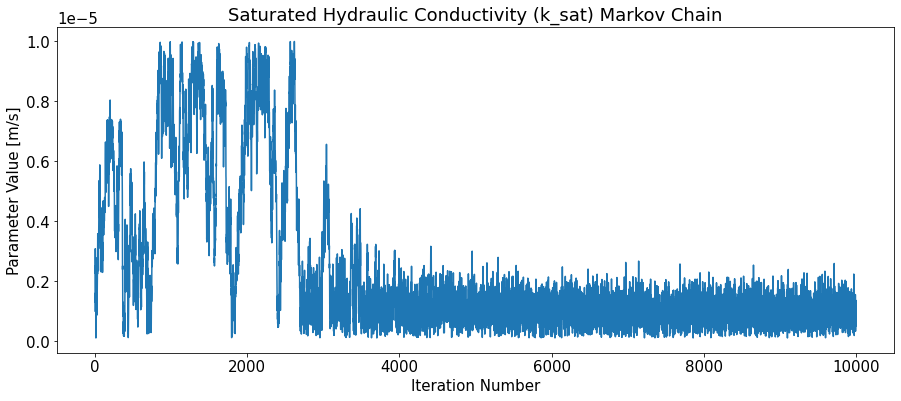

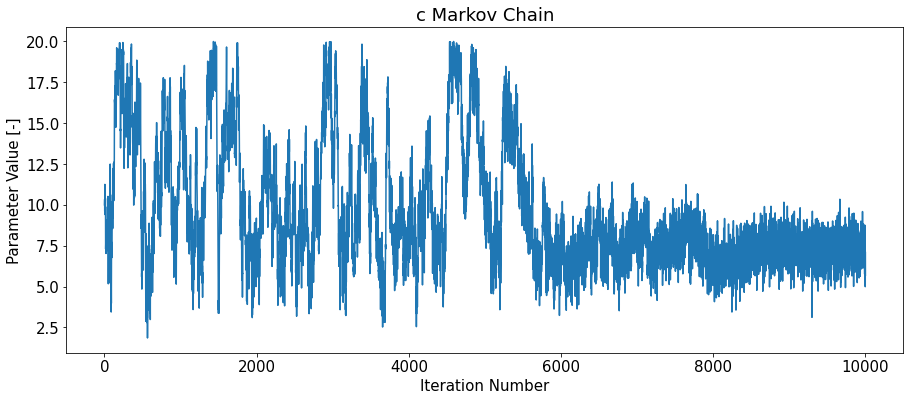

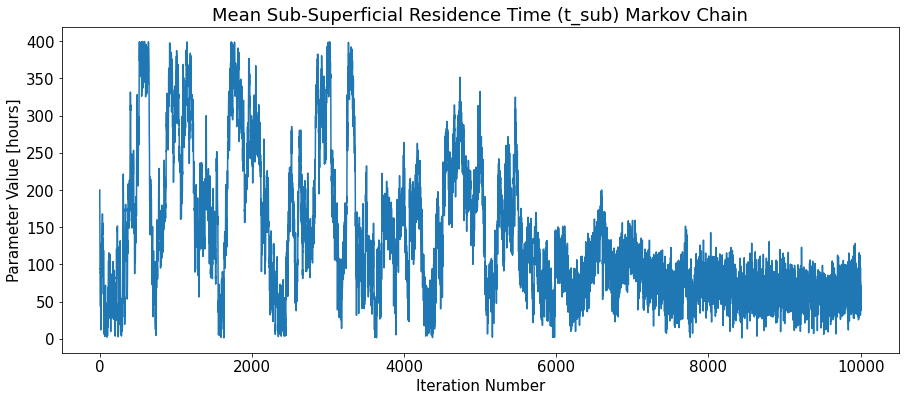

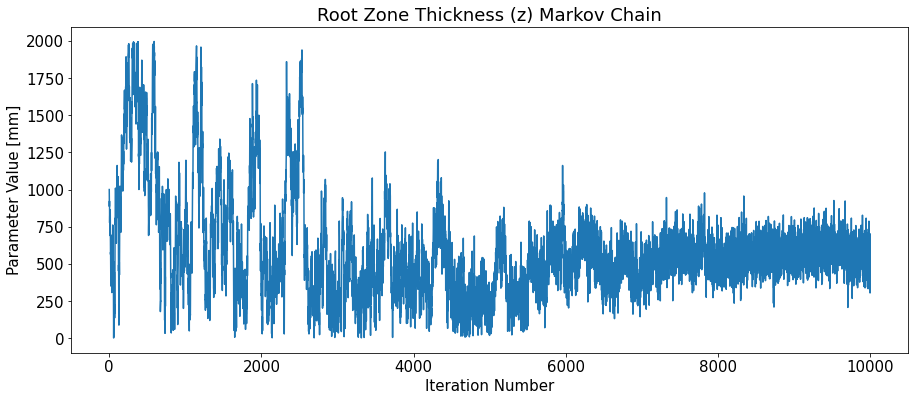

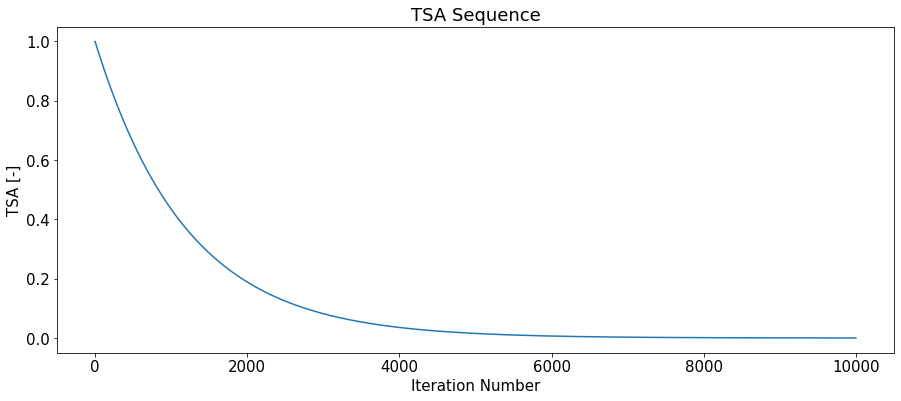

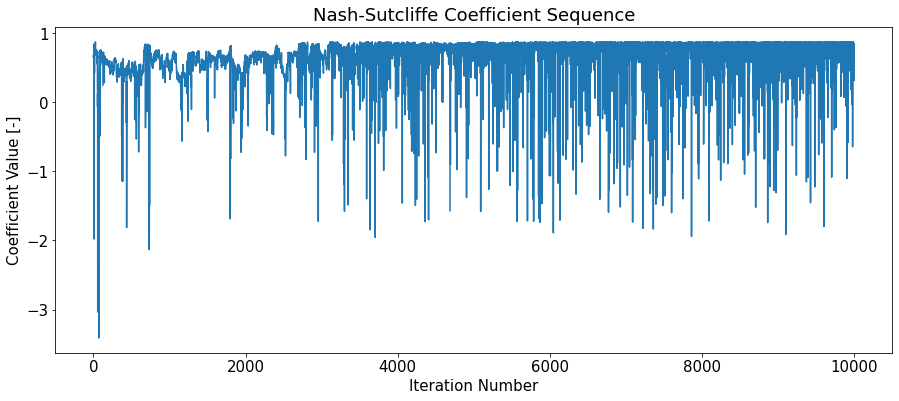

In [21]:
titles = ['Saturated Hydraulic Conductivity (k_sat) Markov Chain', 'c Markov Chain',
           'Mean Sub-Superficial Residence Time (t_sub) Markov Chain', 'Root Zone Thickness (z) Markov Chain',
           'TSA Sequence', 'Nash-Sutcliffe Coefficient Sequence']
y_axes = ['Parameter Value [m/s]', 'Parameter Value [-]', 'Parameter Value [hours]', 'Parameter Value [mm]',
            'TSA [-]', 'Coefficient Value [-]']

for col, title_label, y_lab in zip(list(all_iterations.drop('Unnamed: 0', axis=1).columns),titles,y_axes):
    plt.figure()
    plt.plot(all_iterations[col])
    plt.title(title_label)
    plt.ylabel(y_lab)
    plt.xlabel('Iteration Number')

## 3. Modelling 100 Years of Precipitation Data

### 3.1 Single Pulse Rainfall Model

To model out 100 years worth of rainfall data a single pulse rainfall model will be used. This model assumes that at the daily timescale that rain fall events are uncorrelated with eachother and neglects the temporal variability of rainfall within a rainfall process. What this means is that the chance of rain on any given day is the same regardless of how many times it has rained before and that during a rainy day it is assumed that the rainfall amount is constant. Rainfall events this way will be modelled using a poisson process.

The process will be described using two random variables: the event inter-arrival $(\tau)$ and the precipitation depth $(I)$. In a poisson process the variable in question ($p$ in the example) is exponentially distributed with the following characteristics 

Probability Density Funciton
$$f(x)=pe^{-px}\text{, where }x>0$$
Cumulative Probability Function
$$F(x) = P[X<x]=1-e^{-px}$$
Mean
$$\left< x \right> = 1/p$$
Variance
$$\sigma^{2}(x) = 1/p^{2}$$

In the case of rainfall data the two probability functions will be as follows:

$f(\tau)=\lambda e^{-\lambda\tau} \rightarrow \left<\tau\right>=1/\lambda$

$f(i)=\frac{1}{\alpha} e^{\frac{i}{\alpha}} \rightarrow \left<I\right>=\alpha$

The mean inter-arriaval ($\tau$) can be estimated as $\tau =\frac{\text{n. of days}}{\text{n of rainy days}}$ and $\lambda=\frac{1}{\left<\tau\right>}$, while the mean precipitation ($\alpha$) can be estimated as $\alpha = \frac{\sum I_{i}}{\text{n. of rainy days}}$. To account for intra-annual variability of rainfall these values will be estimated for each month of each year and then averaged.

### 3.2 - Calculate Statistics From Observed Precipitation Data

In [22]:
#upscaling observed rainfall from hourly timescale to daily timescale

#reshape data to get data of each day in one array
P_aranged = np.reshape(P, [int(len(P)/24) ,24])
#sum data of each day to get the daily precipitation data
P_daily = np.sum(P_aranged, axis=1)

print(np.sum(P_daily)/6)
print(P_aranged.shape)

707.2463166666666
(2190, 24)


In [23]:
#compute monthly statistics of 6 month
#get month start and end
day_month=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) 
month_end=np.cumsum(day_month)                     
month_start=month_end-day_month+1

#reshape P_daily into [number of days per year, number of years]
Nyears_P = 6
P_day_year=np.reshape(P_daily,[Nyears_P,365]) 

#define some variables we need later
mean_monthly_P= np.zeros(12)                  #monthly mean precipitation  
std_monthly_P= np.zeros(12)                  #monthly precipitation standard deviation 
rain_days= np.zeros(12) 
no_rain_days=np.zeros(12) 
P_month = np.zeros([Nyears_P,12]) #holder for each month's rain data. shape is (years, months)
temp_rain_days = np.zeros([Nyears_P,12]) #holder for each month's rainy days. shape is (years, months)

#iterate over month
for m in range(12):  
    P_temp = P_day_year[:,month_start[m]-1:month_end[m]]  #temporary matrix with shape (6,days in month)
    P_month[:,m] = np.sum(P_temp, axis=1) #sums all rain for month m over each year in the month column of P_month
    temp_rain_days[:,m] = np.count_nonzero(P_temp,axis=1) #gets the number of rainy days for month m over each year into the month column of temp_rain_days

#calculate monthly mean, standard deviation, and number of rain days/ not rain days on yearly average
mean_monthly_P = np.mean(P_month,axis=0) #mean over each column
std_monthly_P = np.std(P_month,axis=0) #std over each column
rain_days = np.mean(temp_rain_days, axis=0) #mean over each column
no_rain_days= day_month - rain_days

#calculate the parameters alpha and lambda
par_tau = day_month/rain_days
par_lambda = rain_days/day_month
par_alpha = mean_monthly_P/rain_days


Create a function that can output the monthly statistics given rain data so that the code above can be easily run several times. This is the same code as above just generalized as a function.

In [24]:
def get_P_statistics(P):
    #get month start and end
    day_month=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) 
    month_end=np.cumsum(day_month)                     
    month_start=month_end-day_month+1

    #reshape P_daily into [number of days per year, number of years]
    Nyears_P = int(len(P)/365)
    P_day_year=np.reshape(P,[Nyears_P,365])

    #define some variables we need later
    mean_monthly_P= np.zeros(12)                  #monthly mean precipitation  
    std_monthly_P= np.zeros(12)                  #monthly precipitation standard deviation 
    rain_days= np.zeros(12) 
    no_rain_days=np.zeros(12) 
    P_month = np.zeros([Nyears_P,12]) #holder for each month's rain data. shape is (years, months)
    temp_rain_days = np.zeros([Nyears_P,12]) #holder for each month's rainy days. shape is (years, months)
    #iterate over month
    for m in range(12):  
        P_temp = P_day_year[:,month_start[m]-1:month_end[m]]  #temporary matrix with shape (6,days in month)
        P_month[:,m] = np.sum(P_temp, axis=1) #sums all rain for month m over each year in the month column of P_month
        temp_rain_days[:,m] = np.count_nonzero(P_temp,axis=1) #gets the number of rainy days for month m over each year into the month column of temp_rain_days

    #calculate monthly mean, standard deviation, and number of rain days/ not rain days on yearly average
    mean_monthly_P = np.mean(P_month,axis=0) #mean over each column
    std_monthly_P = np.std(P_month,axis=0) #std over each column
    rain_days = np.mean(temp_rain_days, axis=0) #mean over each column
    no_rain_days= day_month - rain_days

    #calculate the parameters alpha and lambda
    par_tau = day_month/rain_days
    par_lambda = rain_days/day_month
    par_alpha = mean_monthly_P/rain_days

    return mean_monthly_P,std_monthly_P,rain_days,no_rain_days,par_tau, par_lambda,par_alpha

### 3.3 Using the Calculated Statistics in Practice

To use the values calculated above to model new data a random probabilty will need to be sampled from the exponential probability distribution and to do this easily the Inverse Tranformation Method will be used. The idea behind this method is that one is able to randomly sample from a probability density function using uniform probability density function. In this method the following are the uniform probability distribution function (this can be simulated using `np.random.uniform()`) and its cumulative probability function 
$$f_{u}(u), \quad F_{u}(u)=P[U<u]=u$$ 

and the following are the exponentially distributed probability density function from the poisson process and its cumulative probability function
$$f(x)=pe^{-px} , \quad F(x) = P[X<x]=1-e^{-px}$$

The inverse transformation method states that 
$$x_{i} = F^{-1}\left( F_{u}(u_{i}) \right)$$
and therefore
$$x_{i} = F^{-1}(u_{i})$$
This means that if a randomly drawn number from a uniform probability density distribution is drawn and inputted into the inverse of the cumulative probability function of the exponentially distributed probability function a value from that exponentially distributed probability function can be drawn.


### 3.4 Create function to create model data for n-years

`rain_amount_mm` the average rain intensity based on the observed rain data, draws a number from a random distribution between 0 and 1 and then uses the inverse transform method to obtain a probability from the distribution function that represents the intensity of rain.

In [25]:
def rain_amount_mm(alpha):
    u = np.random.rand()
    xi = -log(1-u)*alpha # This is the inverse of the cumulative probabilty function
    return xi

def precipitation_model(lam, alpha, Nyears):
    # lam and alpha should be per month values

    # create variables for days in months
    day_month=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) 
    month_end=np.cumsum(day_month) # Julien day of month start    
    month_start=month_end-day_month+1 # Julien day of month end

    day_to_month_map = np.zeros(365,int) #This is a mapping where you can input a day and it will give you a month index
    i=0                              #eg. Jan=0, feb=1, march=2
    j=0
    for month in day_month:
        for day in range(month):
            day_to_month_map[i] = j
            i+=1
        j+=1


    P_mod = np.zeros([Nyears,365]) # Create holder for genertated rainfall

    for year in range(Nyears):
        for day in range(365):
            month = day_to_month_map[day] # To obtain the correct alpha and lambda
            if np.random.rand() < lam[month]: # If it rains
                P_mod[year,day] = rain_amount_mm(alpha[month]) # Input the intensity of the rain event

    return P_mod
    

### 3.5 Model Precipitation Data and Compare to Observed Data (Deliverable 5)

In [26]:
P_mod = precipitation_model(par_lambda, par_alpha, 100)

P_mod
mn, std, rain_d, n_rain_d,mnth_tau,mnth_lam,mnth_alpha = get_P_statistics(P_mod.reshape(-1))

__Deliverable 5:__ Plot the comparison between the statistics (mean, standard deviation, α and λ) of the observed and generated precipitation.

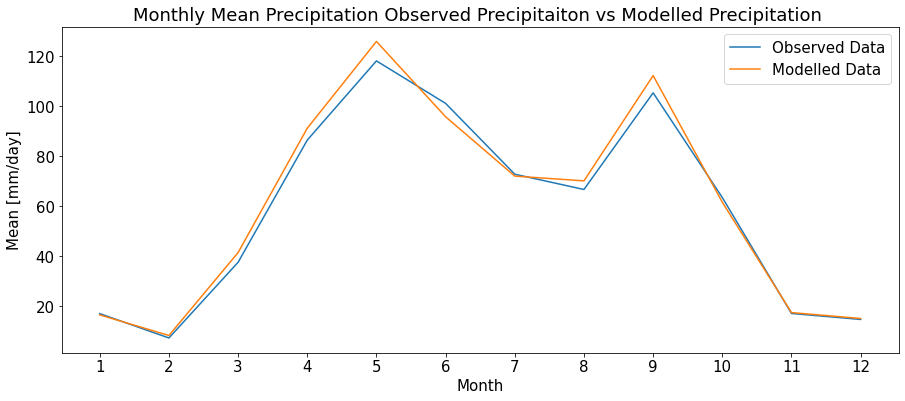

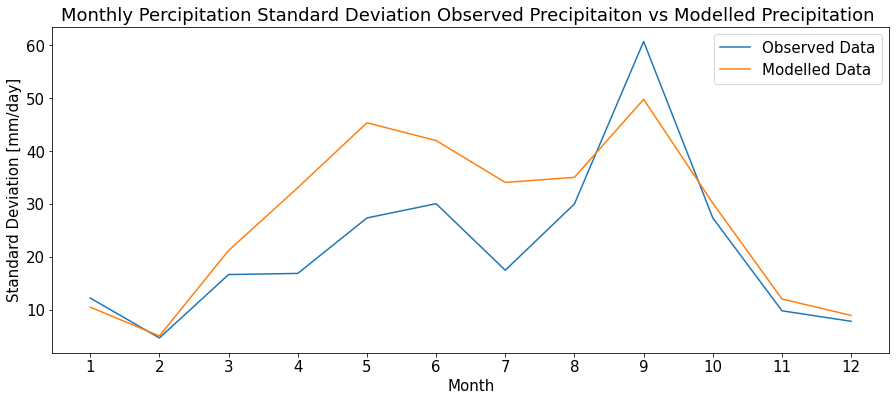

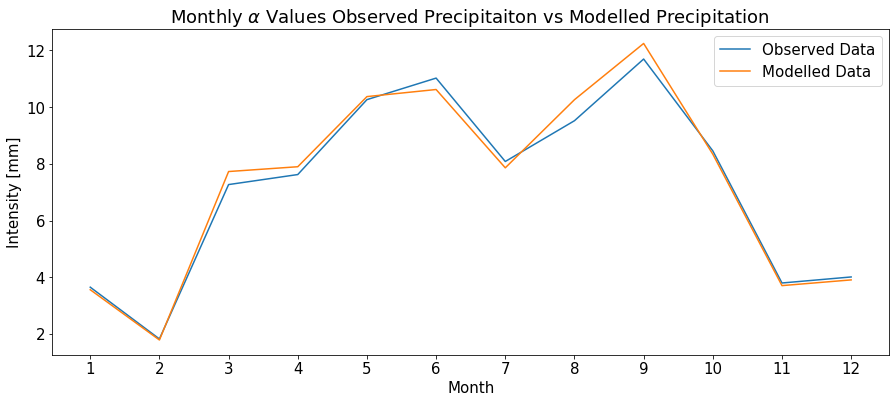

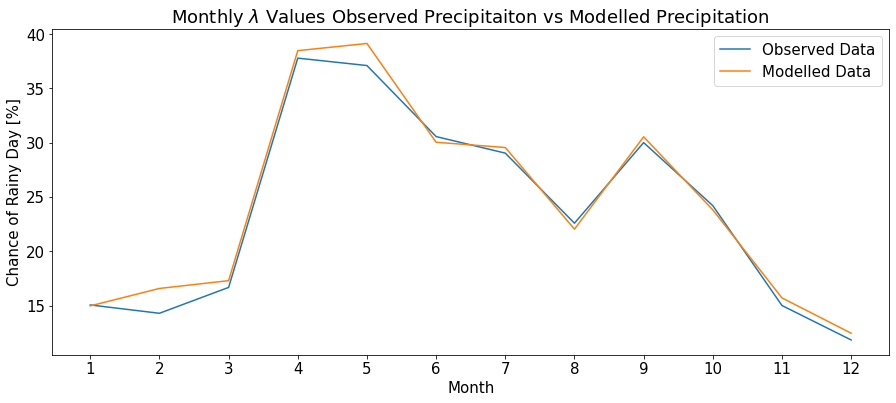

In [27]:
#Gather data into lists so that it can be plotted in a for loop
info = [(mean_monthly_P,mn),(std_monthly_P, std), (par_alpha, mnth_alpha), (par_lambda*100,mnth_lam*100) ]
titles = ['Monthly Mean Precipitation', 'Monthly Percipitation Standard Deviation', 
            'Monthly $\\alpha$ Values', 'Monthly $\\lambda$ Values']
y_axes = ['Mean [mm/day]', 'Standard Deviation [mm/day]', 'Intensity [mm]', 'Chance of Rainy Day [%]']

#run for loop and plot all figures
for (old,new), title, ylab in zip(info, titles, y_axes):
    plt.figure()
    plt.plot(old, label= 'Observed Data'),
    plt.plot(new, label= 'Modelled Data'),
    plt.legend()
    plt.title(f'{title} Observed Precipitaiton vs Modelled Precipitation ')
    plt.ylabel(ylab)
    plt.xlabel('Month')
    plt.xticks(ticks=range(12), labels=(range(1,13,1)))

### 3.6 Run Modelled Precipitation Data through catchment model and Plot Results (Deliverable 6)

It appears as though the modeld values line up with the values obtained from the provided data other than the standard deviation, but that could possibly be explained by the difference in number of years.

Before the modelled rain data can be put through the hydrological model it needs to be downscaled so that it is in [mm/h] instead of [mm/day]. To do this the TAs for the course have provided a downscaling function that has been copied and pasted into the cell below

In [28]:
#downscale function from TAs
def downscaling(Pdaily):
    """
    Downscale daily precipitation to hourly precipitation assuming that hourly
    rainfall are exponentially distributed.

    INPUT
    "Pdaily": precipitation at daily timestep

    OUTPUT
    "Phourly": precipitation at hourly time step 

    if "Pdaily" is in [mm/day], "Phourly" is in [mm/h]     

    """

    Phourly = np.empty((len(Pdaily)*24,))
    for i in range(len(Pdaily)):
        distr = -np.log(np.random.rand(24,))
        sumdistr = np.sum(distr)
        Phourly[i*24:(i+1)*24] = Pdaily[i]*distr/sumdistr

    return Phourly

To downscale the data a single column vector matrix will need to be inputted into the downscaling function and then that data can be put into the catchment model function. 

If the code is being run separately from the code before the following cell can be uncommented and run to reload the best parameters. the iteration number may need to be changed.

In [29]:
# final_params = pd.read_csv('./project_data/group_S_final_params_1.csv')
# k_sat = final_params['k_sat'].loc[0]
# c = final_params['c'].loc[0]
# z = final_params['z'].loc[0]
# t_sub = final_params['t_sub'].loc[0]

In [30]:
P_downscaled = downscaling(P_mod.reshape(-1))

ET_pot_kc_list = ET_pot_n_kc(temp, phi, 100,kc)

print(k_sat, c, z, t_sub)
Q_tot_100, R_100, I_100, s_100, L_100, ET_100 = catchment_model(k_sat, c, t_sub, z, P_downscaled, 100, ET_pot_kc_list)


9.580109260824428e-07 7.274280748138227 549.5347911482665 68.38553952326873


__Deliverable 6:__ Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in [mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in [mm/h] for the calibrated hydrological model forced by the generated precipitation).

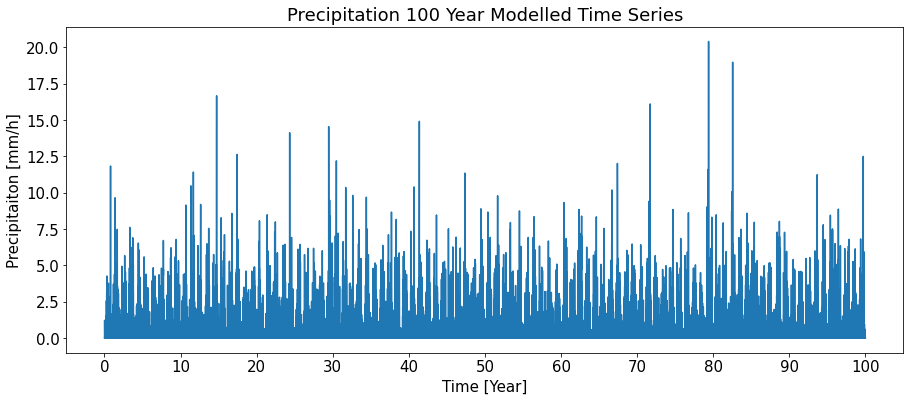

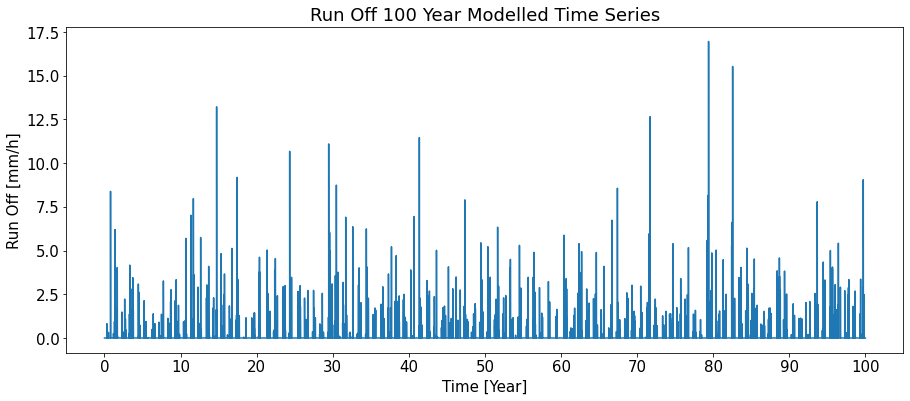

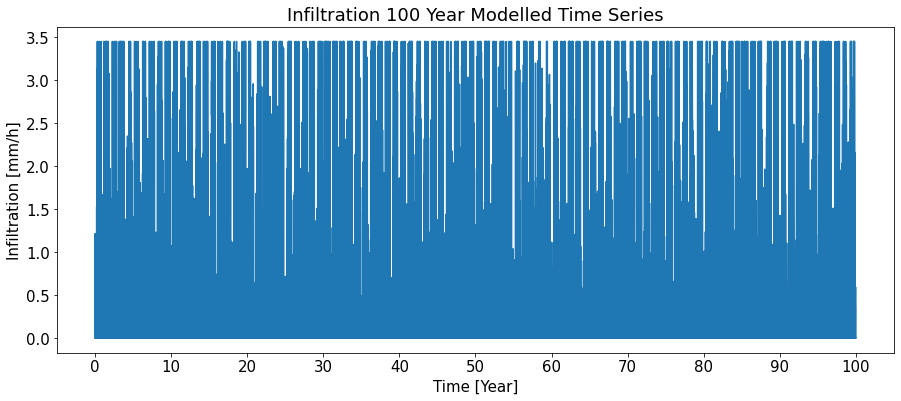

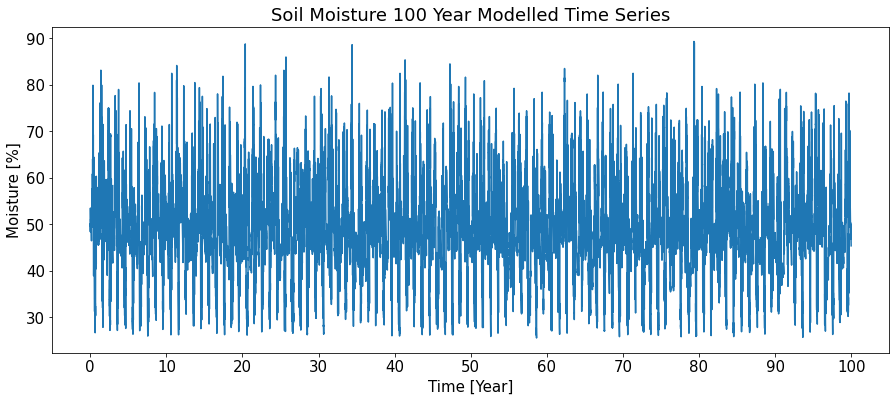

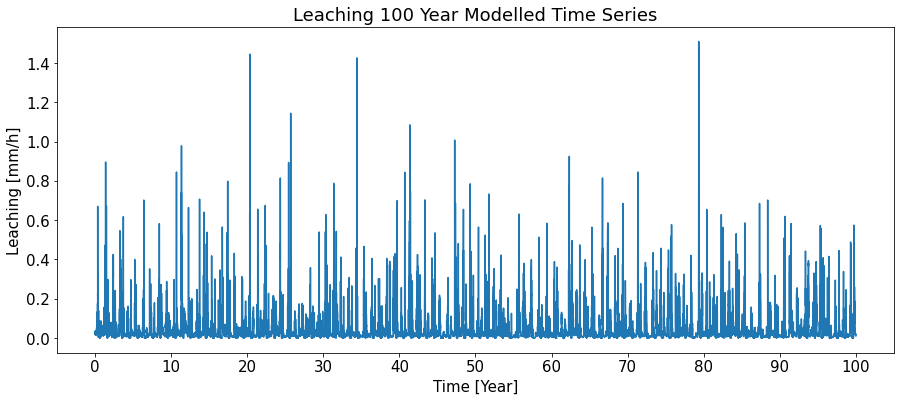

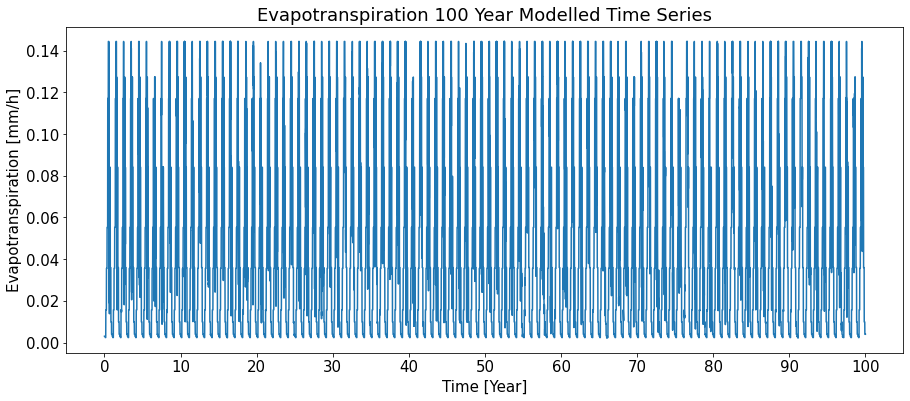

In [31]:
#First convert data from m/h to mm/h as needed. Note that ET was in m^3/h so it needs to be divided by area
P_mm, R_mm, I_mm, L_mm, ET_mm, s_perc = P_downscaled, R_100*1000, I_100*1000, L_100*1000, ET_100*1000/(4000*1000000), s_100*100

#Gather data into lists so that it can be plotted in a for loop
info = [P_mm, R_mm, I_mm, s_perc, L_mm, ET_mm ]
titles = ['Precipitation', 'Run Off', 'Infiltration', 'Soil Moisture', 'Leaching', 'Evapotranspiration']
y_axes = ['Precipitaiton [mm/h]', 'Run Off [mm/h]', 'Infiltration [mm/h]', 'Moisture [%]', 'Leaching [mm/h]', 'Evapotranspiration [mm/h]']

#create a vectorized function to edit labels
def round_label(x):
    return round(x)
rounder = np.vectorize(round_label)

#run for loop and plot all figures
for var, title, ylab in zip(info, titles, y_axes):
    plt.figure()
    plt.plot(var)
    plt.title(f'{title} 100 Year Modelled Time Series')
    plt.ylabel(ylab)
    plt.xlabel('Time [Year]')
    plt.xticks(ticks=np.arange(0,len(var)+8760,8760*10), labels= rounder(np.arange(0,len(var)/8760+1, 10)))

## Part 4: Modelling a Multi-Purpose Reservoir

The Reservior to be modelled will be expected to provide flood control to the down stream area, produce electricity through the use of a turbine, and garunetee a minimum flow be let through at all times. The reservoir has a drum gate in which the flow can be altered as needed and a spill way at 19m above the bottom of the lake. The main variable that will be varied in this exercise will be the maximum allowable level in the resevoir. The higher this level is set in the reservoir the more water is available for power generation, but also the less room there is in the reservoir to prevent flooding. The relationship between maximum level, electricity production, flood risk will be explored in this section.

### 4.1 Equations for a Reservoir

To model a Reservoir several equations will need to be used. Like the hydrological model made in __Part 1__ of this report a water storage equation will be required and is written as follows:
$$ \frac{dV(t)}{dt}=Q_{in}(t) - Q_{out}(l(V(t))) - Q_{HU}(t)$$
where $Q_{in}(t)$ describes the discharge entering the reservoir as modelled from the hydrological model, $Q_{out}(l(V(t)))$ is the discharge leaving the reservoir which is a function of the level in the reservoir, and $Q_{HU}(t)$ which is the discharge to the turbine

#### 4.1.1 Equations for $Q_{out}(t)$

There are two ways that water can leave the reservoir other than being used to generate electricity. It can either leave through the sluice gate if the water level is below the spill way, or through both the sluice gate and the spill way if the water level is above the height of the spill way.

The sluice gate will be operated so that it only let's out a minimum amount of water ($Q_{347}$) if the level of the reservoir is below the maximum reservoir level, if the level of the reservoir is above the maximum reservoir level the sluice gate will attempt to let out enough water to bring the reservoir level back down to the maximum level in the time step while not going above $Q_{lim}$. $Q_{lim}$ is the maximum allowable outflow of the reservoir. 

The above conditions for operation of the sluice gate can be modelled using the following equation where $V_{max,HU}$ is the volume at the maximum reservoir level:
$$
\begin{equation}
  Q_{g}(t) = max
    \begin{cases}
      Q_{347}\\
      min\begin{cases} 
          \frac{V(t)+\left[ Q_{in}(t)-Q_{HU} \right]*\Delta t - V_{max,HU}}{\Delta t }\\
          Q_{lim}
          \end{cases}
    \end{cases}       
\end{equation}
$$

The spillway of the reservoir will come into operation when the level of the reservoir reaches above that of the spillway level and can be modelled with the following equation where $C_{q,sp}$ is the discharge coefficient of the spillway, $L$ is the spillway length, $g$ is gravity acceleration, $l$ is the reservoir level and $p$ is the spillway crest height:
$$Q_{sp}(t) = C_{q,sp}L\sqrt{2g(l-p)^{3}} \quad \text{for $l>p$}$$

With the two above equations $Q_{out}$ can be calculated as the following:
$$
\begin{equation}
  Q_{out}(t) =
    \begin{cases}
      Q_{g}(t) & \text{for $l\le p$}\\
      Q_{g}(t) + Q_{sp}(t) & \text{for $l>p$}
    \end{cases}       
\end{equation}
$$


#### 4.1.2 Power Generation

In this reservoir model power will only be generation between the hours of 06:00 and 22:00. The generator will only be run if at 00:00 the level of the reservoir is below the maximum reservoir level. Otherwise the generator will not run that entire day. The equation to calculate the amount of power generated in Watts is the following where $\eta$ is the efficiency of the generator, $\gamma$ is the specific weight of water, $Q_{HU}$ is the discharge to the generator, and $h_{T}$ is the turbine head :
$$P=\eta \gamma Q_{HU} h_{T}$$

### 4.2 Creating level rating curve and volume rating curve (Deliverable 7)

It is important for the to model to be able to relate the level of the lake to the volume of water within it. Since the lake is not a prism this will be done through the use of a area rating curve provided to the group. Using the area rating curve, a volume rating curve will be produced using trapezoidal integration via the `integrate.cumtrampz` function from the `scipy` library.

In [32]:
#create Volume Curve
area_curve = np.loadtxt(data+'area_rating_curve.txt', skiprows=2)
lake_area = area_curve[:,1]
level = area_curve[:,0]
volume_curve = integrate.cumtrapz(lake_area,level, initial=0)

__Deliverable 7:__ Plot the area and the volume rating curves for the given levels.

[Text(0.5, 0, 'Level [m]'), Text(0, 0.5, 'Volume $m^3$')]

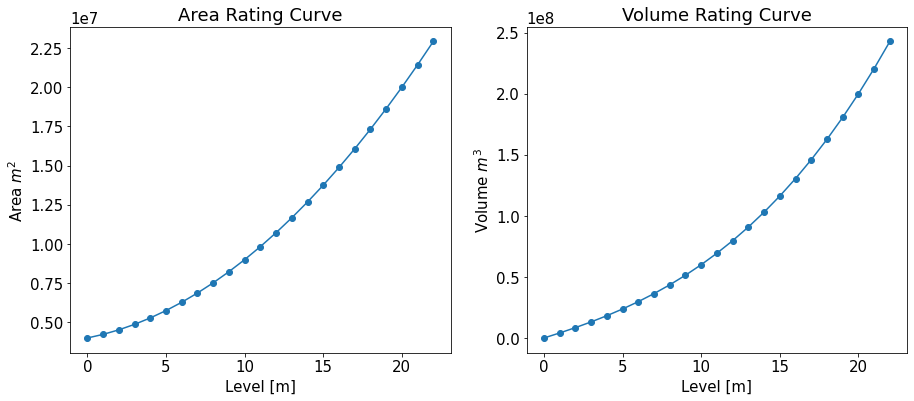

In [33]:
fig, axs = plt.subplots(1,2)
axs[0].plot(area_curve[:,1],'-o')
axs[0].set_title('Area Rating Curve')
axs[0].set(xlabel= 'Level [m]', ylabel='Area $m^2$')
axs[1].plot(volume_curve, '-o')
axs[1].set_title('Volume Rating Curve')
axs[1].set(xlabel= 'Level [m]', ylabel='Volume $m^3$')

### 4.3 Obtain Minimum Flow $Q_{347}$ (Deliverable 8)

To obtain the minimum flow (the flow that is exceeded 95%) the $Q_{out}$ data from the catchment model that was run for the 100 year modelled precipitation data will be sorted in ascending order and the then the value that is exceeded 95% of the time will be indexed out of the sorted list. This will be done via the `get_Q_347` function.

In [34]:
#calculate Q 347
#make a function

def get_Q_347(Q_tot_100):
 Q_sor = sorted (Q_tot_100)
 Q_347 = Q_sor[ceil(len(Q_tot_100)*0.05)]
 return Q_347

#level volume 
def get_level(volume, volume_curve):
    return np.interp(volume,volume_curve, range(len(volume_curve)))

def get_volume(level, volume_curve):
    return np.interp(level, range(len(volume_curve)),volume_curve)
    


__Deliverable 8:__ Report the minimum flow (discharge that is equalled or exceeded 95% of the time) of the generated discharge and plot the discharge duration curves.

8.024467460132415
The minimum flow is 8.02 m^3/s


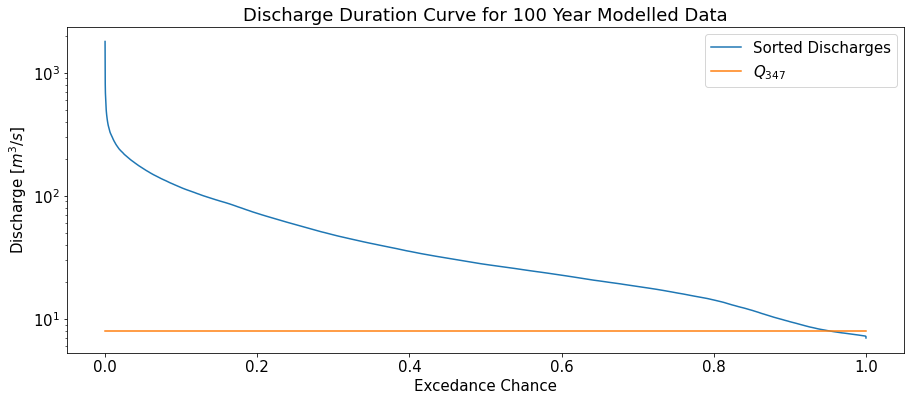

In [35]:
#discharge duration curve
Q347=get_Q_347(Q_tot_100)
print (Q347)
Qsor=sorted(Q_tot_100)
Qsor.sort(reverse=True)
Qlen=len(Q_tot_100)
a=list(range(1,Qlen+1))
pex=np.divide(a, Qlen)

plt.figure()
plt.semilogy(pex,Qsor, label='Sorted Discharges')
plt.plot([0, 1],[Q347, Q347], label='$Q_{347}$')
plt.title('Discharge Duration Curve for 100 Year Modelled Data')
plt.xlabel('Excedance Chance')
plt.ylabel('Discharge [$m^3/s$]')
plt.legend()
 

print(f'The minimum flow is {round(Q347, 2)} m^3/s')

### 4.4 Create a Model for the Reservoir

Using the information gathered above a model of the reservoir can be created that loops through each hour of $Q_in$ data from the hydrological model (starting at Janurary 1st 00:00) simulating how the multipurpose reservoir behaves.

`power_generated` is a function that takes in a flow value and reservoir level and outputs the amount of energy that is produced

In [36]:
#function to calculate power
def power_generated(Q_HU, level):
    h_t = level+75 #[m] The turbine is 75m below the empty reservoir
    gamma = 9806 #[N/m^3] From prior assignment, specific weight of water
    return 0.73*gamma*Q_HU*h_t # [W]

`reservoir_model` is a function that takes in an array of hourly $Q_{in}$ discharge in [$m^{3}/s$], the maximum allowable reservoir level, and the volume rating curve of the reservoir. It returns array vectors containing the power generated at each hour [$W$], the flow to the generator at each hour [$m^3/s$], the volume of the reservoir at each hour [$m^3$], the discharge out of the reservoir at each hour [$m^3/s$], the level of the reservoir at each hour [$m$] and the flow out of the sluice gate at each hour [$m^3/s$].

In [37]:
#assume that the volume starts so that the level is at the max level for power production
#set up arrays so that they are days x hours
def reservoir_model(Q_in, HUmax, volume_curve):
    Nyears = int(len(Q_in)/8760)
    Q_in = Q_in.reshape(Nyears*365,24) #convert into array days x hours array should be m^3/s 

    #write variables and convert units if needed
    p = 19 # [m] This is the level of the spill way
    HUmin = 7 # [m] This is the minimum height for electricity production
    Cq_sl = 0.6 # [-]
    Cq_sp = 0.7 # [-]
    length_spillway = 14 #[m]
    Q_lim = 100 # [m^3/s]
    Q_T = 35 # [m^3/s] from notes this is a constant
    g = 9.806 # [m/s^2]

    #create matrixes to hold data
    power_gen = np.zeros((Nyears*365, 24))
    Q_HU = np.zeros((Nyears*365, 24))
    V_res = np.zeros((Nyears*365+1, 24)) # one extra row for the euler method to store
    Q_out = np.zeros((Nyears*365, 24))
    level_res = np.zeros((Nyears*365, 24))
    Q_g = np.zeros((Nyears*365, 24))

    # calculate Q347 
    Q347 = get_Q_347(Q_in.flatten()) # [m^3/s]
    #calculate volume at HU max (15 m) (Christina)
    V_HU = get_volume(HUmax, volume_curve)
    #set initial volume
    V_res[0,0] = V_HU

    #loop through each day
    for day in range(Q_in.shape[0]):
        #determine if turbine runs today
        level_res[day,0] = get_level(V_res[day,0],volume_curve)
        turbine_runs = HUmin<level_res[day,0]<HUmax #This is a stored boolean

        #loop through each hour
        for hour in range(24):
            level_res[day,hour] = get_level(V_res[day,hour],volume_curve)

            #caluclate power and flow to turbine if turbine runs and its between 6h and 22h
            if 6<=hour<22 and turbine_runs:
                Q_HU[day,hour] = Q_T
                power_gen[day, hour] = power_generated(Q_T, level_res[day,hour])

            #Calculate Q_g
            Q_g[day,hour] = max(
                Q347,
                min(
                    (V_res[day,hour]+(Q_in[day,hour]-Q_HU[day,hour])*3600-V_HU)/3600,
                    Q_lim
                )
            )

            #caluclate Q_out
            if level_res[day,hour]<=p:
                Q_out[day,hour] = Q_g[day,hour]
            else:
                Q_out[day,hour] = Q_g[day,hour] + Cq_sp*length_spillway*(2*g*(level_res[day,hour]-p)**3)**0.5            

            if hour<23: #This is here because when its the 23rd index we don't have an hour+1 slot
                #caluclate new volume (with Euler)
                V_res[day,hour+1] = V_res[day,hour] + (Q_in[day,hour] - Q_out[day,hour] - Q_HU[day,hour])*3600

            else: #if the hour is the last hour in the day
                #caluclate new volume (with Euler)
                V_res[day+1,0] = V_res[day,hour] + (Q_in[day,hour] - Q_out[day,hour] - Q_HU[day,hour])*3600

        # Note that for the volume atrix there are extra values due to the array needing to store a t+1 value
        # Units are [W], [m^3/s], [m^3], [m^3/s], [m], [m^3/s]
    return power_gen.flatten(), Q_HU.flatten(), V_res.flatten()[:-23], Q_out.flatten(),level_res.flatten(), Q_g.flatten()
            


### 4.5 Run Reservoir Model with Maximum Reservoir Height as 15m and Plot Results (Deliverable 9)

In [38]:
power_g,Q_hu,vres,Q_out,levelres,Q_g = reservoir_model(Q_tot_100,15,volume_curve)

In [39]:
# Check that the lengths of arrays are correct
# the volume array should have 1 extra value

print(f'The length of the power_g array is {len(power_g)}')
print(f'The length of the Q_hu array is {len(Q_hu)}')
print(f'The length of the vres array is {len(vres)}')
print(f'The length of the Q_out array is {len(Q_out)}')
print(f'The length of the levelres array is {len(levelres)}')
print(f'The length of the Q_g array is {len(Q_g)}')

The length of the power_g array is 876000
The length of the Q_hu array is 876000
The length of the vres array is 876001
The length of the Q_out array is 876000
The length of the levelres array is 876000
The length of the Q_g array is 876000


__Deliverable 9:__ For a maximum level for hydroelectric use of 15 m, plot the time series (100 years long) of input discharge, output discharge, volume within the reservoir and level.

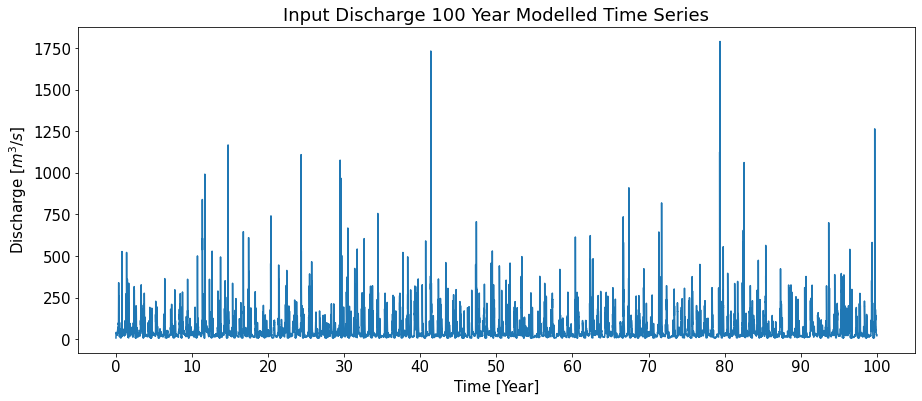

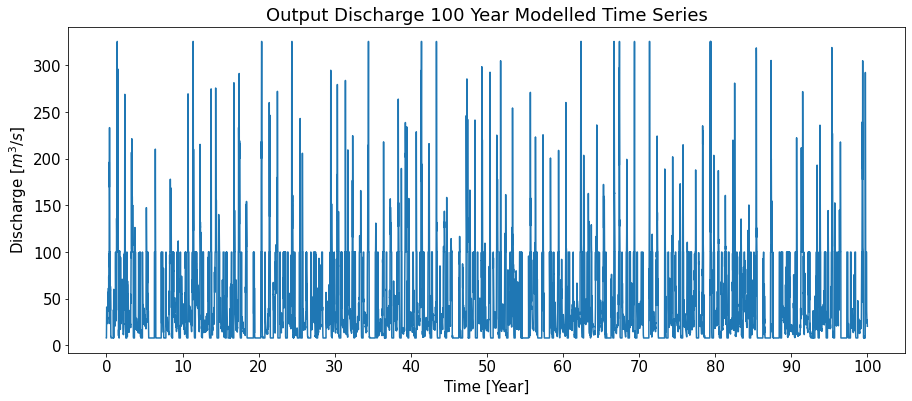

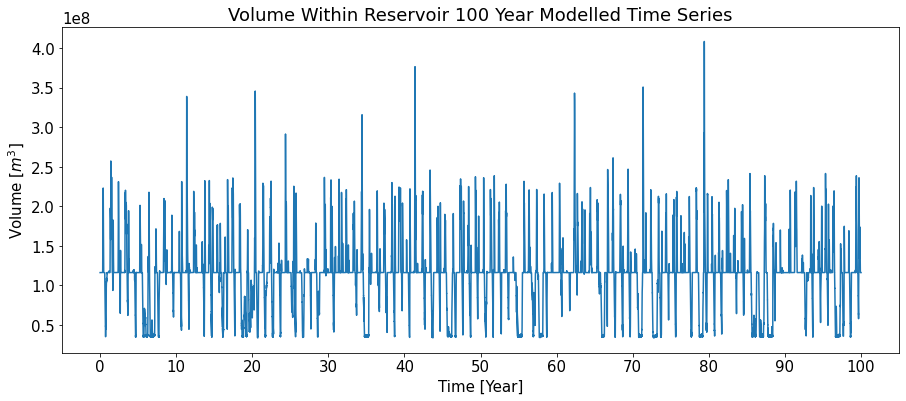

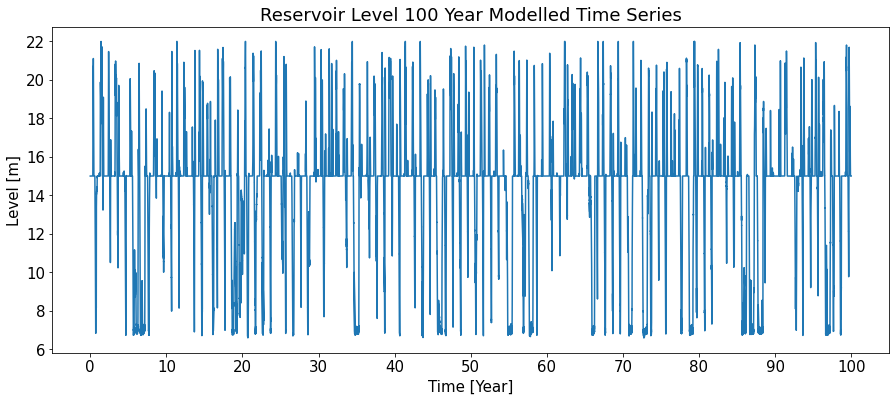

In [40]:
#Gather data into lists so that it can be plotted in a for loop
info = [Q_tot_100, Q_out, vres, levelres]
titles = ['Input Discharge', 'Output Discharge', 'Volume Within Reservoir', 'Reservoir Level']
y_axes = ['Discharge [$m^3/s$]', 'Discharge [$m^3/s$]', 'Volume [$m^3$]', 'Level [m]']

#create a vectorized function to edit labels
def round_label(x):
    return round(x)
rounder = np.vectorize(round_label)

#run for loop and plot all figures
for var, title, ylab in zip(info, titles, y_axes):
    plt.figure()
    plt.plot(var)
    plt.title(f'{title} 100 Year Modelled Time Series')
    plt.ylabel(ylab)
    plt.xlabel('Time [Year]')
    plt.xticks(ticks=np.arange(0,len(var)+8760,8760*10), labels= rounder(np.arange(0,len(var)/8760+1, 10)))

### 4.6 Run Reservoir Model for Various Maximum Levels and Plot Results (Deliverable 10 and 11)

The model will be run for maximum height values of 8m to 19m in increments of 1m to find how different maximum reservious level heights impact the annual energy production and flood probability.

In [41]:
# The results will be stored in a pandas DataFrame after for ease of plotting
results = []

# Create a funciton to obtain times when the flow was above Q_lim
Q_lim = 100
above_Q_lim = np.vectorize(lambda x: 1 if x > (Q_lim +1) else 0)

for max_hu in tqdm(range(9,20,1)): #Frome 9->19
    power_g, Q_hu, vres, Q_out, levelres, Q_g = reservoir_model(Q_tot_100,max_hu,volume_curve)

    # First calculate the average annual produced electricity
    # power_g is currently in [W] and needs to be in [GWh]
    power_g_GWH_annual = power_g/1000 # change [W] to [kWh], since the data is already in hours it just needs to be multipled by 1 [hour]
    power_g_GWH_annual = power_g_GWH_annual.reshape(8760, int(len(power_g_GWH_annual)/8760)) # Reshape so that values can be summed over the year
    power_g_GWH_annual = power_g_GWH_annual.sum(axis=0)/1000/1000 #sum power outputed each year and change units to [GWh]
    power_g_GWH_annual = power_g_GWH_annual.mean() # Take the mean over all of the year
    
    # Now to calculate the flood probability
    Q_lim_passed = above_Q_lim(Q_out)
    row= {
        'annual_power_gen':power_g_GWH_annual,
        'flood_prob': Q_lim_passed.sum()/len(Q_lim_passed), #probability is number of times Qlim exceeded/total hours
        'max_height': max_hu
    }
    results.append(row)

100%|██████████| 11/11 [02:05<00:00, 11.37s/it]


In [42]:
data_df = pd.DataFrame(results)
data_df.head()

,annual_power_gen,flood_prob,max_height
0,9.495996,0.055282,9
1,11.594561,0.058209,10
2,14.264028,0.061257,11
3,17.057865,0.064287,12
4,19.886735,0.068276,13


__Deliverable 10:__ Plot the average annual energy production in [GWh] and the probability that $Q_{out}$ exceeds $Q_{lim}$ for different values of the maximum level for hydroelectrical use.

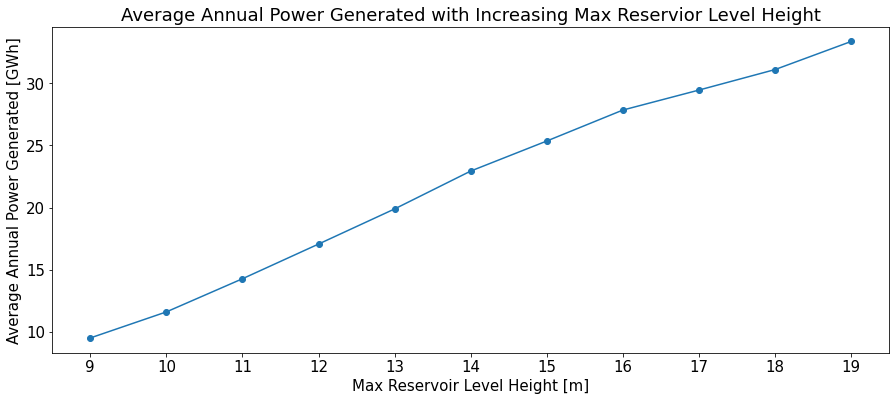

In [43]:
plt.figure()
plt.plot(data_df.max_height, data_df.annual_power_gen,'-o')
plt.title('Average Annual Power Generated with Increasing Max Reservior Level Height')
plt.ylabel('Average Annual Power Generated [GWh]')
plt.xlabel('Max Reservoir Level Height [m]')
plt.xticks(ticks=range(9,20,1), labels=range(9,20,1))
plt.show()

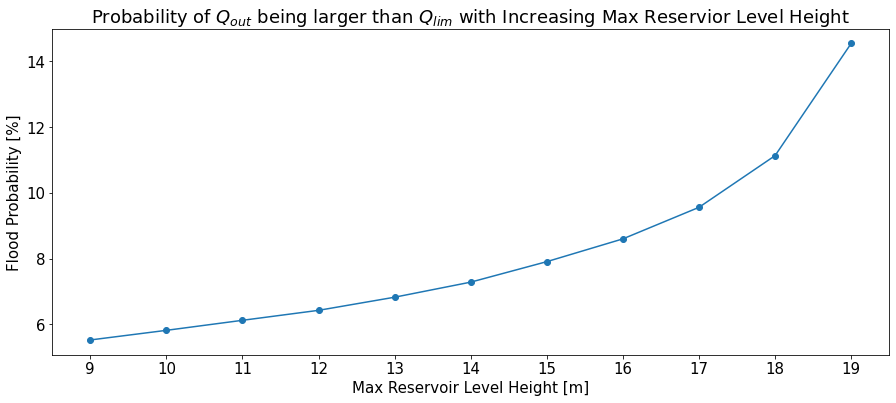

In [44]:
plt.figure()
plt.plot(data_df.max_height, data_df.flood_prob*100,'-o')
plt.title('Probability of $Q_{out}$ being larger than $Q_{lim}$ with Increasing Max Reservior Level Height')
plt.ylabel('Flood Probability [%]')
plt.xlabel('Max Reservoir Level Height [m]')
plt.xticks(ticks=range(9,20,1), labels=range(9,20,1))
plt.show()

__Deliverable 11:__ Plot the Pareto front of average annual energy production in [GWh] vs the probability that Qout exceeds Qlim computed from different values of the maximum level for hydroelectrical use.

The Pareto front shows us what the bounding line of possible events are given data and using the pareto front it can be determined how the Flood Probability relates to the average annual power that is able to be generated. The area below the curve outlines the possible solutions.

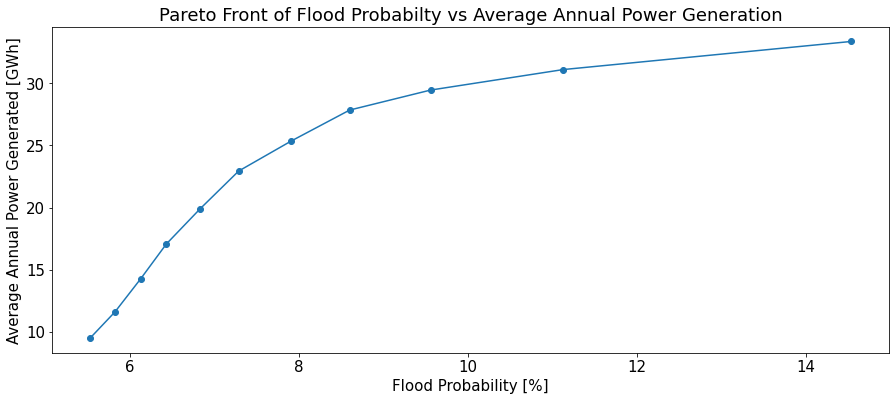

In [45]:
plt.figure()
plt.plot(data_df.flood_prob*100, data_df.annual_power_gen,'-o')
plt.title('Pareto Front of Flood Probabilty vs Average Annual Power Generation')
plt.ylabel('Average Annual Power Generated [GWh]')
plt.xlabel('Flood Probability [%]')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5df487f7-59ba-4cf0-a19f-3d475f8b72c8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>